## Week 4 Individual Assignment - Bikeshed

In this assignment, I am working off of Week 4's lab in order to creat a bike shed for a potential area of study between Beverly Hills and Central LA (Beverly Grove) to understand what bike networks people that live in this area have access to. Further, we can also see how the addition of bikeways in this network hole can do for regional connectivity.

#### Importing our necessary libraries.

In [31]:
# for spatial data
import geopandas as gpd

# for plotting
import matplotlib.pyplot as plt

# for network analysis
import networkx as nx

# for street network analysis
import osmnx as ox

# for basemaps
import contextily as ctx

#### Setting our location, mode, times, and speed.

In [32]:
# configuring the place, network type, trip times, and travel speed
address = 'Beverly Grove, Los Angeles, CA, USA'
network_type = 'bike'
trip_times = [5, 10, 15, 20] #in minutes
meters_per_minute = 400 # travel distance per minute

#### Downloading our study area from OSMnx

In [34]:
%%time
# download the street network
G = ox.graph_from_address(address, network_type=network_type, dist=3000)

CPU times: user 7.05 s, sys: 34.9 ms, total: 7.08 s
Wall time: 7.09 s


In [35]:
# checking our data type
type(G)

networkx.classes.multidigraph.MultiDiGraph

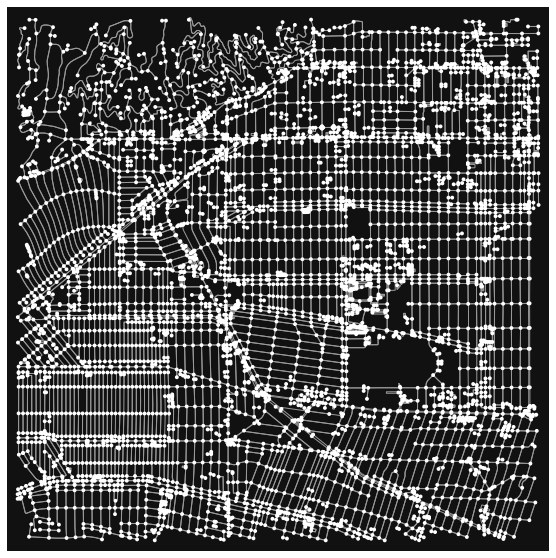

In [37]:
# plotting to check study area
fig, ax = ox.plot_graph(G,figsize=(10,10))

In [38]:
# project our network data to Web Mercator (measurements are in meters)
G = ox.project_graph(G, to_crs='epsg:3857')

#### Converting to Geodataframes

In [39]:
# convert nodes and edges to geodataframes
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

<AxesSubplot:>

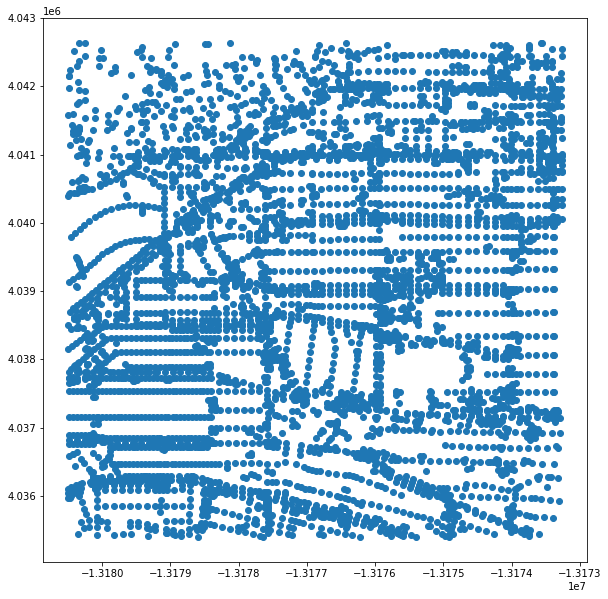

In [40]:
# plotting our nodes
gdf_nodes.plot(figsize=(10,10))

<AxesSubplot:>

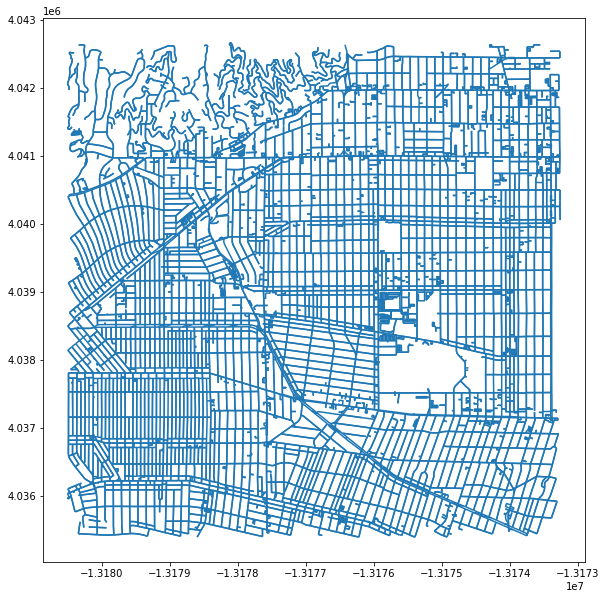

In [41]:
# plotting our edges
gdf_edges.plot(figsize=(10,10))

In [42]:
# Calculate network statistics, ignoring the warning because it gives us an output anyway
stats = ox.basic_stats(G, circuity_dist='euclidean')
stats

/opt/conda/lib/python3.9/site-packages/osmnx/stats.py:317: UserWarning: The `circuity_dist` argument has been deprecated and will be removed in a future release.
  warnings.warn(msg)


{'n': 5405,
 'm': 15145,
 'k_avg': 5.604070305272895,
 'edge_length_total': 1268548.9009999982,
 'edge_length_avg': 83.76024437107945,
 'streets_per_node_avg': 3.0377428307123036,
 'streets_per_node_counts': {0: 0,
  1: 742,
  2: 63,
  3: 2907,
  4: 1644,
  5: 41,
  6: 7,
  7: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.13728029602220165,
  2: 0.011655874190564292,
  3: 0.5378353376503238,
  4: 0.30416281221091584,
  5: 0.0075855689176688255,
  6: 0.0012950971322849213,
  7: 0.00018501387604070305},
 'intersection_count': 4663,
 'street_length_total': 671430.4250000012,
 'street_segment_count': 8132,
 'street_length_avg': 82.56645659124462,
 'circuity_avg': 0.8594903918158454,
 'self_loop_proportion': 0.0025823905558288243}

#### Finding the center point in our study area

In [43]:
# get the bounding box coordinates, min and max for both x and y
minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
print(minx)
print(miny)
print(maxx)
print(maxy)

-13180505.518844813
4035395.4259140394
-13173259.176591627
4042638.698236758


In [44]:
# calculate the centroid
centroid_x = (maxx-minx)/2 + minx
centroid_y = (maxy-miny)/2 + miny
print(centroid_x)
print(centroid_y)

-13176882.34771822
4039017.062075399


In [46]:
# use osmnx's distance.nearest_nodes command to get the id for the nearest node
center_node = ox.distance.nearest_nodes(G,Y=centroid_y,X=centroid_x)

# this record is the center point of our study area
gdf_nodes.loc[[center_node]]

,y,x,highway,street_count,lon,lat,geometry
osmid,,,,,,,
1718692981,4.039020e+06,-1.317689e+07,traffic_signals,4,-118.37002,34.076066,POINT (-13176890.329 4039020.357)


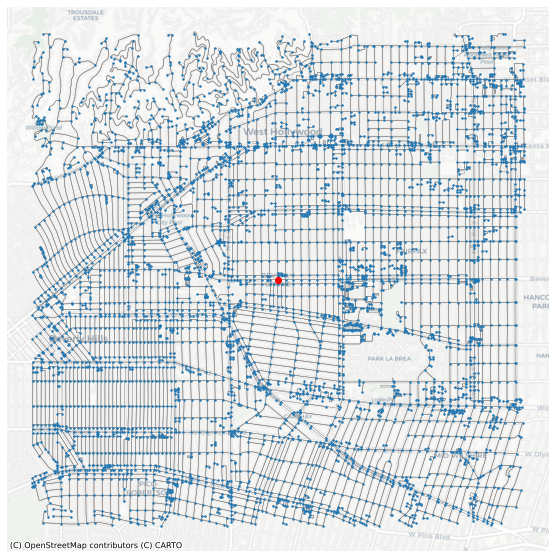

In [47]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# adding all edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               edgecolor='gray', 
               zorder=10)

# add all nodes to ax
gdf_nodes.plot(ax=ax, 
               markersize=2, 
               zorder=20)

# adding a red center point to ax
gdf_nodes.loc[[center_node]].plot(ax=ax,
                                  color='r', 
                                  zorder=30)

# no axis
ax.axis('off')

# adding a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,zoom=14)

In [49]:
# checking our data
gdf_edges[['osmid','name','highway','length']].sample(5)

,,,osmid,name,highway,length
u,v,key,,,,
2780591344,5158756595,0,522352313,Havenhurst Drive,residential,12.745
7568296978,7568296978,1,809424886,NaN,service,98.176
123132772,123132770,0,159608579,South Crescent Heights Boulevard,tertiary,115.923
122783136,9073102947,0,165555550,West 9th Street,residential,64.401
1717893789,703066806,0,382742188,South Clark Drive,residential,261.539


#### Adding a Biking Time column to our data

In [50]:
# create a new column and calculate the time it takes to travel that edge
gdf_edges['bike_time'] = gdf_edges['length']/meters_per_minute

In [51]:
gdf_edges[['osmid','name','highway','length','bike_time']].sample(10)

,,,osmid,name,highway,length,bike_time
u,v,key,,,,,
1717893554,6479671900,0,398597580,West Sunset Boulevard,secondary,29.167,0.072918
122895523,703066375,0,397994422,Robertson Boulevard,secondary,166.178,0.415445
122813166,122813168,0,829788348,Packard Street,residential,55.885,0.139712
123384194,123330317,0,186401260,West 8th Street,tertiary,106.513,0.266283
4808149977,3754574920,0,"[398019897, 398019890]",South La Brea Avenue,primary,147.835,0.369587
1717816308,6807622543,0,159669976,Hawthorn Avenue,residential,31.971,0.079927
122731475,5167709167,0,13406924,Roxbury Road,residential,60.262,0.150655
123020202,8410987175,0,437981853,North Sierra Bonita Avenue,residential,126.288,0.315720
122694794,123608253,0,13438986,Marmont Avenue,residential,80.492,0.201230


#### Adding color to each trip time

In [52]:
# assign a color hex code for each trip time isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap='plasma', 
                                start=0, 
                                return_hex=True)
print(trip_times)
print(iso_colors)

[5, 10, 15, 20]
['#0d0887', '#9c179e', '#ed7953', '#f0f921']


In [53]:
# reversing the order of colors so that the darker color matches longer times
trip_times.sort(reverse=True)
print(trip_times)
print(iso_colors)

[20, 15, 10, 5]
['#0d0887', '#9c179e', '#ed7953', '#f0f921']


In [54]:
# create a list of "zipped" time/colors, this means that the trip time and color are in the same value in the series
time_color = list(zip(trip_times, iso_colors))
time_color

[(20, '#0d0887'), (15, '#9c179e'), (10, '#ed7953'), (5, '#f0f921')]

#### Finding how many nodes are reachable for each trip time

In [55]:
# loop through each trip time and color
for time, color in list(time_color):

    # for each trip time, create an egograph of nodes that fall within that distance
    subgraph = nx.ego_graph(G, center_node, radius=time)

    print('There are ' + str(len(subgraph.nodes())) + ' nodes within ' + str(time) + ' minutes ')
    
    # for each of those nodes, update the gdf_nodes dataframe and assign it with its associated distance color
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = str(time) + ' mins'
        gdf_nodes.loc[node,'color'] = color

There are 1270 nodes within 20 minutes 
There are 680 nodes within 15 minutes 
There are 259 nodes within 10 minutes 
There are 74 nodes within 5 minutes 


#### Adding color (gray) to all nodes that fall outside of a 20 minutes bike ride

In [56]:
# the NaN values then need to be populated with a valid color
gdf_nodes['color'].fillna('#cccccc', inplace=True)

#### Plotting our map

<AxesSubplot:>

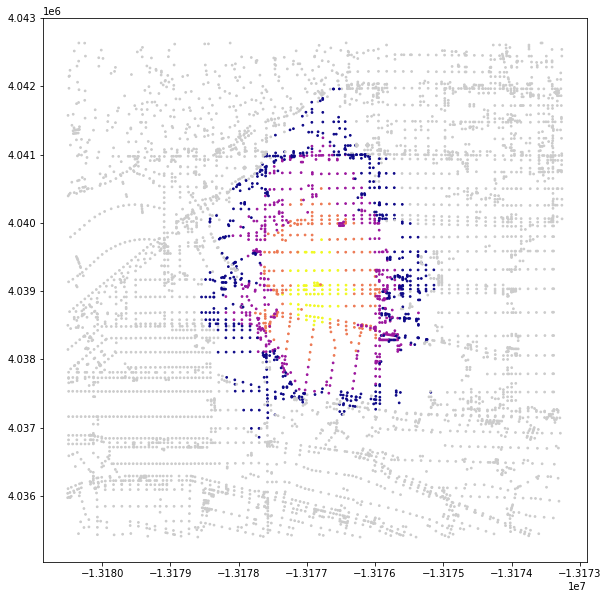

In [57]:
# mapping it
gdf_nodes.plot(figsize=(10,10),
               color=gdf_nodes['color'],
               markersize=3)

#### Creating a "full" map by adding a basemap to contextualize our findings

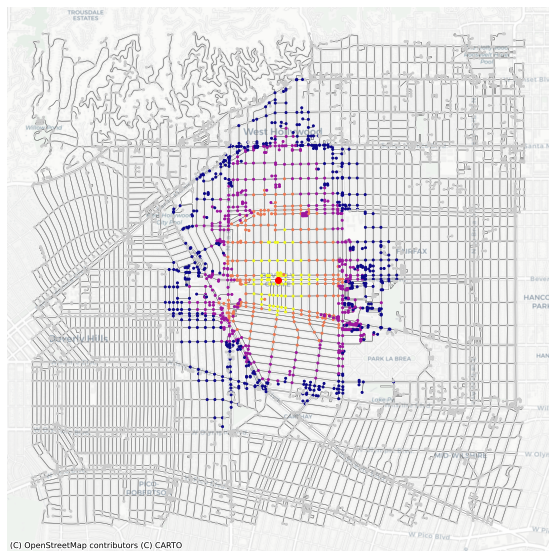

In [58]:
# a "full" map
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# adding all edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               edgecolor='gray', 
               zorder=10)

# adding all nodes to ax
gdf_nodes.plot(ax=ax,
               color=gdf_nodes['color'],
               markersize=4, 
               zorder=20)

# adding a red center node to ax
gdf_nodes.loc[[center_node]].plot(ax=ax,
                                  color='r', 
                                  zorder=30)

# no axis
ax.axis('off')

# adding basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,zoom=14)